<a href="https://colab.research.google.com/github/miguel-fc/Neutron_Reflect/blob/main/nr_v15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/miguel-fc/Neutron_Reflect.git

Cloning into 'Neutron_Reflect'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 166 (delta 24), reused 39 (delta 10), pack-reused 106
Receiving objects: 100% (166/166), 15.54 MiB | 7.19 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [2]:
# Import Python related required packages
import io
import os
import cv2
import gdown
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde, norm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import pickle

#Import torch related packages
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset, TensorDataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
#Set these important parameters
#Dimension of the latent space 
d = 3
#Dimension of the graphs
in_d1 = 2
in_d2 = 72
#Number of epochs
num_epochs = 1000
#Number of layers
num_layers = 3
#Number of neurons
num_neur=500 


In [4]:
cd Neutron_Reflect/

/content/Neutron_Reflect


In [5]:
#Stored those numpy arrays
data_path = './data/'
expt_arr = np.load(os.path.join(data_path,'mod_expt.npy'))
# expt_arr_o = np.loadtxt(os.path.join(data_path,'flipped_sorted_no_nano_expt.dat')).T
# expt_arr = np.zeros_like(expt_arr_o)
# # expt_arr[0] = 1791.5076453352374 - expt_arr_o[0]
# expt_arr[0] = expt_arr_o[0]
# expt_arr[1] = expt_arr_o[1]
sld_arr = np.load(os.path.join(data_path,'mod_sld_fp49.npy'))
params_arr = np.load(os.path.join(data_path,'mod_params_fp49.npy'))
# t_sld_arr = np.load(os.path.join(data_path,'train_data.npy'))
# params_arr = np.load(os.path.join(data_path,'train_pars.npy'))

In [6]:
expt_arr.shape ,sld_arr.shape, params_arr.shape, sld_arr.dtype, params_arr.dtype, expt_arr.dtype

((2, 72),
 (5942, 2, 72),
 (5942, 3),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

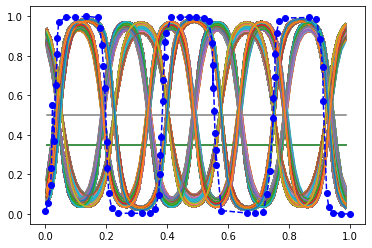

In [7]:
for x in range(sld_arr.shape[0]):
  plt.plot(sld_arr[x][0],sld_arr[x][1])
plt.plot(expt_arr[0],expt_arr[1],'bo',linestyle='dashed')

In [8]:
#Import packages from the github clone
import data_preparation as dpre
import AutoEnc as au
import MLP as mlp

In [9]:
#Prepare data files
xtrain, ytrain, xval, yval, xtest, ytest = \
dpre.split_input_arrays(sld_arr,params_arr, size_split=0.8)

xtrain.shape, ytrain.shape, xval.shape, yval.shape, xtest.shape, ytest.shape
(4753, 2, 72) (4753, 3) (594, 2, 72) (594, 3) (595, 2, 72) (595, 3)


In [10]:
#Prepare data files, continuation
train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = \
dpre.get_dataloaders_fromsplitarrays(xtrain,ytrain,xval,yval,xtest,ytest,batch_size=50)

In [11]:
loss_fn = torch.nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [12]:
def initialize_model(d,in_d1,in_d2,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  encoder = au.Encoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)
  decoder = au.Decoder(encoded_space_dim=d,dim1=in_d1,dim2=in_d2,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': encoder.parameters()},
     {'params': decoder.parameters()}
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return encoder, decoder, optim

In [13]:
#Initialize autoencoder
encoder, decoder, optim = initialize_model(d,in_d1,in_d2,num_layers,num_neur)

#train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = au.fit(encoder,decoder,device,train_loader,loss_fn,optim)
  val_loss = au.val(encoder,decoder,device,valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)
  # plot_ae_outputs(model,train_dataset,device,n=10)

EPOCH 1/1000 	 train loss 0.08439978212118149 	 val loss 0.06332093477249146
EPOCH 2/1000 	 train loss 0.024058334529399872 	 val loss 0.0015690603759139776
EPOCH 3/1000 	 train loss 0.0006359999533742666 	 val loss 0.0009358274401165545
EPOCH 4/1000 	 train loss 0.0004999839584343135 	 val loss 0.000754611857701093
EPOCH 5/1000 	 train loss 0.0004625509900506586 	 val loss 0.000688302970957011
EPOCH 6/1000 	 train loss 0.0004527154378592968 	 val loss 0.0006616049213334918
EPOCH 7/1000 	 train loss 0.0003714797494467348 	 val loss 0.0005444398266263306
EPOCH 8/1000 	 train loss 0.0003111672995146364 	 val loss 0.00032550739706493914
EPOCH 9/1000 	 train loss 0.000247455871431157 	 val loss 0.00043248635483905673
EPOCH 10/1000 	 train loss 0.00035093585029244423 	 val loss 0.00033850714680738747
EPOCH 11/1000 	 train loss 0.00018850213382393122 	 val loss 0.0002591633819974959
EPOCH 12/1000 	 train loss 0.0001728585921227932 	 val loss 0.0002489303005859256
EPOCH 13/1000 	 train loss 0

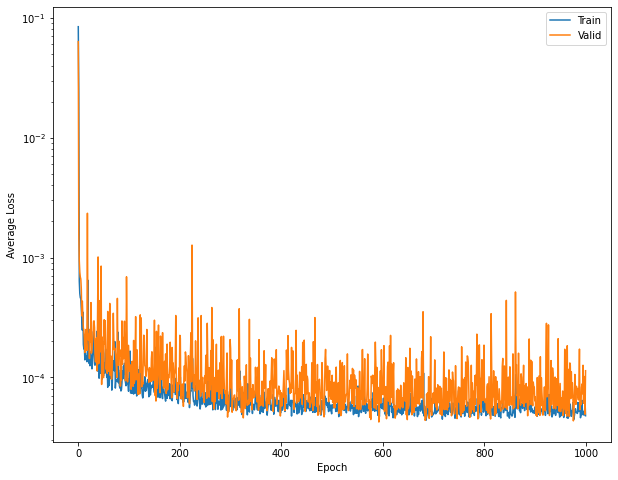

In [14]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

For image 0, the loss = 0.00010618615488056093
For image 1, the loss = 4.721616278402507e-05
For image 2, the loss = 2.1376023141783662e-05
For image 3, the loss = 0.0002259688189951703
For image 4, the loss = 0.00013701875286642462
For image 5, the loss = 2.036229670920875e-05
For image 6, the loss = 6.920727901160717e-05
For image 7, the loss = 0.0002118611882906407
For image 8, the loss = 3.5742261388804764e-05
For image 9, the loss = 7.556661876151338e-05


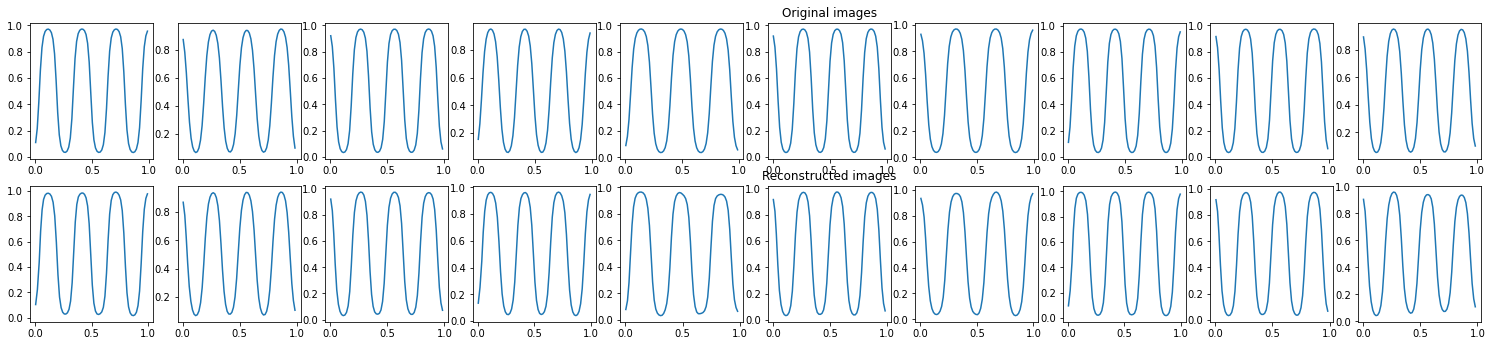

In [15]:
au.test(encoder,decoder,test_dataset,device,loss_fn,in_d1,in_d2,n=10)

tensor([-2.6335e+00, -1.4627e+00,  4.4842e-05])
tensor([2.6614e+00, 1.9974e+00, 2.6226e-05])


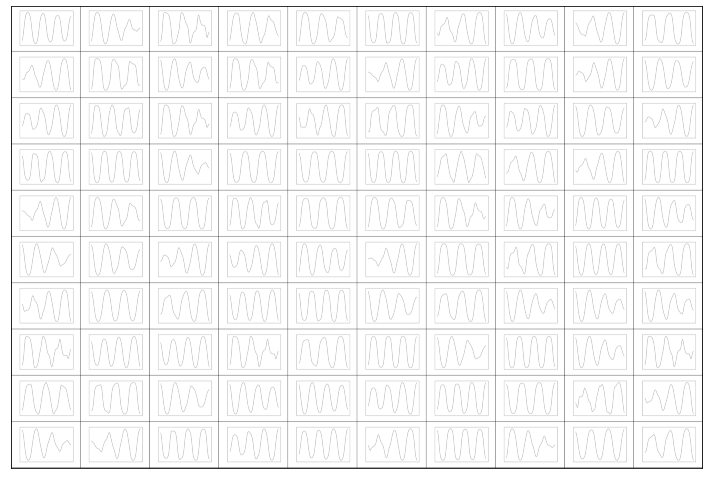

In [16]:
#Interpolating in the latent space
#This is similar to a manifold

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    plt.close()
    img = cv2.imdecode(img_arr,0)

    return img

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = iter(train_loader).next()
    images = images.view(images.size(0), -1).to(device) 

    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)


    latent = torch.randn(200, d)*std + mean
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.view(img_recon.size(0), in_d1,in_d2).cpu()


n_img = []
for i in range(img_recon.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.close()
    ax.plot(img_recon[i][0],img_recon[i][1])
    n_img.append(get_img_from_fig(fig))

n_img = torch.from_numpy(np.asarray(n_img))
n_img = n_img[:,np.newaxis,:,:]

fig, ax = plt.subplots(figsize=(20, 8.5))
show_image(torchvision.utils.make_grid(n_img[:100],10,5))
plt.show()

In [17]:
nlabel = params_arr.shape[1]
# nlabel

for i in range(nlabel):
  label_index = 'label'+str(i)
  # print(label_index)

In [18]:
encoded_samples = []
for sample in train_dataset:
    img = sample[0].unsqueeze(0)
    img = img.view(img.size(0), -1).to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    # print(enumerate(encoded_img))
    encoded_sample = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      encoded_sample[label_index] = label_val[i].numpy()
    # encoded_sample['label1'] = label[1].numpy()
    # encoded_sample['label2'] = label[2].numpy()
    # encoded_sample['label3'] = label[3].numpy()
    encoded_samples.append(encoded_sample)
df_encoded_samples = pd.DataFrame(encoded_samples)
df_encoded_samples

,l1,l2,l3,label0,label1,label2
0,-1.429777,-4.038260,0.000073,0.199,0.134,-0.34423
1,-1.269220,-3.941499,0.000073,0.128,0.578,-0.01027
2,-1.374524,-4.003543,0.000073,0.148,0.328,-0.28886
3,-6.814886,-2.544268,0.000014,0.15,-0.0719,-0.22475
4,-0.535295,-0.105371,0.000055,0.0805,0.544,0.32939
...,...,...,...,...,...,...
4748,-4.847992,1.770684,0.000004,0.123,-0.546,0.49405
4749,-1.392651,-4.012455,0.000073,0.112,0.227,-0.20545
4750,-4.951057,1.780163,0.000003,0.163,-0.0583,0.05316
4751,-6.838619,-2.503671,0.000014,0.183,-0.221,-0.19231


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


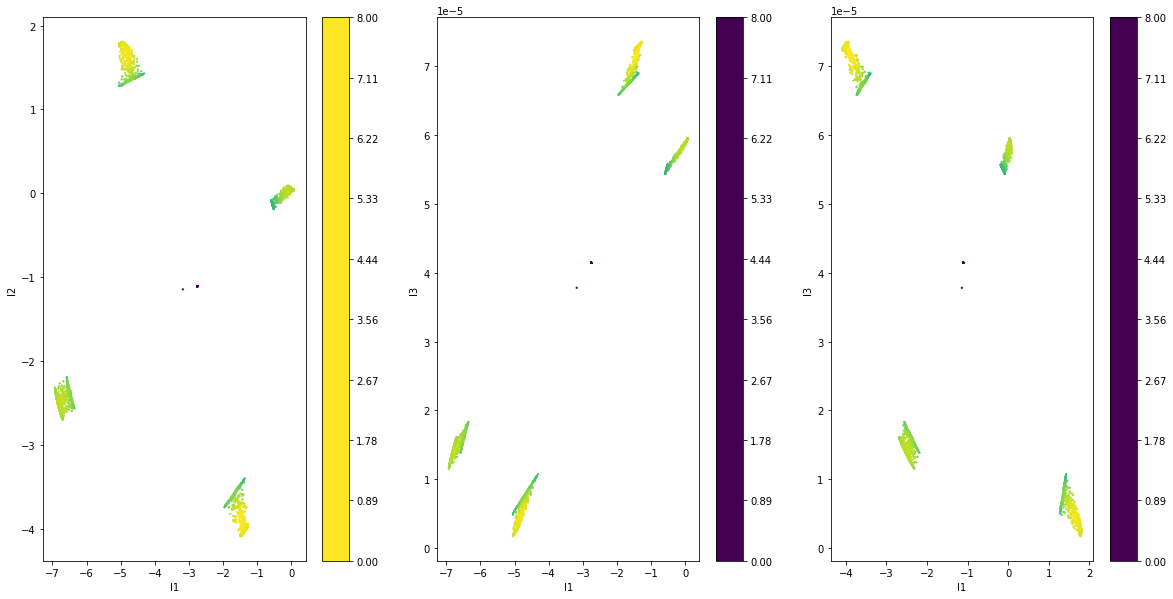

In [19]:
#Plotting the joint distributions for the latent variables

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,3,1)
x = df_encoded_samples['l1']
y = df_encoded_samples['l2']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_ylabel('l2')
ax.set_xlabel('l1')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


ax = fig.add_subplot(1,3,2)
x = df_encoded_samples['l1']
y = df_encoded_samples['l3']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_ylabel('l3')
ax.set_xlabel('l1')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


ax = fig.add_subplot(1,3,3)
x = df_encoded_samples['l2']
y = df_encoded_samples['l3']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_ylabel('l3')
ax.set_xlabel('l1')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');

In [20]:
#Creating dataloaders for the MLP. This includes train, valid and test

img, out_img, train_latent_var, train_labels_var = au.get_latent_variables(encoder,decoder,device,train_loader)
print(img.shape, out_img.shape, train_latent_var.shape, train_labels_var.shape)

img, out_img, valid_latent_var, valid_labels_var = au.get_latent_variables(encoder,decoder,device,valid_loader)
print(img.shape, out_img.shape, valid_latent_var.shape, valid_labels_var.shape)


img, out_img, test_latent_var, test_labels_var = au.get_latent_variables(encoder,decoder,device,test_loader)
print(img.shape, out_img.shape, test_latent_var.shape, test_labels_var.shape)


mlp_train_dataset, mlp_valid_dataset, mlp_test_dataset, mlp_train_loader, mlp_valid_loader, mlp_test_loader = \
dpre.get_dataloaders_fromsplitarrays(train_latent_var.numpy(),train_labels_var.numpy(), \
                                valid_latent_var.numpy(),valid_labels_var.numpy(),\
                                test_latent_var.numpy(),test_labels_var.numpy(), \
                                batch_size=50)

torch.Size([4753, 144]) torch.Size([4753, 144]) torch.Size([4753, 3]) torch.Size([4753, 3])
torch.Size([594, 144]) torch.Size([594, 144]) torch.Size([594, 3]) torch.Size([594, 3])
torch.Size([595, 144]) torch.Size([595, 144]) torch.Size([595, 3]) torch.Size([595, 3])


In [21]:
num_epochs = 1600
num_layers = 1
num_neur = 500

def initialize_mlp(dim,nlabel,num_layers,num_neur):
  lr= 0.001
  torch.manual_seed(0)
  
  model = mlp.MLP(dim=d,nlabel=nlabel,num_layers=num_layers,num_neur=num_neur)

  params_to_optimize = [
     {'params': model.parameters()},
  ]

  optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)


  return model, optim

In [22]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)
model.to(device)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=3, bias=True)
  )
)

In [23]:
#Initialize mlp
model, optim = initialize_mlp(d,nlabel,num_layers,num_neur)

#Train and validate
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
  # print (epoch)
  train_loss = mlp.fit(model,device,mlp_train_loader,loss_fn,optim)
  val_loss = mlp.val(model,device,mlp_valid_loader,loss_fn)
  print('EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
  diz_loss['train_loss'].append(train_loss)
  diz_loss['val_loss'].append(val_loss)

EPOCH 1/1600 	 train loss 0.0463409386575222 	 val loss 0.028638379648327827
EPOCH 2/1600 	 train loss 0.022806508466601372 	 val loss 0.02132011018693447
EPOCH 3/1600 	 train loss 0.021116362884640694 	 val loss 0.02078079618513584
EPOCH 4/1600 	 train loss 0.021863022819161415 	 val loss 0.023241763934493065
EPOCH 5/1600 	 train loss 0.02072656899690628 	 val loss 0.028096752241253853
EPOCH 6/1600 	 train loss 0.020757609978318214 	 val loss 0.020321398973464966
EPOCH 7/1600 	 train loss 0.0196488369256258 	 val loss 0.01997169852256775
EPOCH 8/1600 	 train loss 0.019444173201918602 	 val loss 0.01883751153945923
EPOCH 9/1600 	 train loss 0.01908091828227043 	 val loss 0.021552762016654015
EPOCH 10/1600 	 train loss 0.018579555675387383 	 val loss 0.02048402465879917
EPOCH 11/1600 	 train loss 0.01839219219982624 	 val loss 0.0191416647285223
EPOCH 12/1600 	 train loss 0.018482565879821777 	 val loss 0.01824079640209675
EPOCH 13/1600 	 train loss 0.017823003232479095 	 val loss 0.022

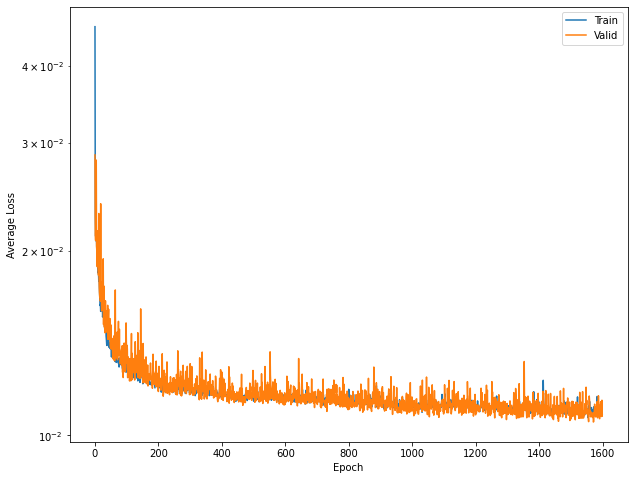

In [24]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [25]:
out_samples = []
for sample in mlp_test_dataset:
    img = sample[0]
    img = img.to(device) 
    label_val = sample[1]
    # print(label_val.shape)
    model.eval()
    with torch.no_grad():
        out_label  = model(img)
    out_label = out_label.cpu().numpy()
    # print(enumerate(encoded_img))
    out_sample = {f"pred_label{i}": enc for i, enc in enumerate(out_label)}
    for i in range(nlabel):
      label_index = 'label'+str(i)
      out_sample[label_index] = label_val[i].numpy()
    out_samples.append(out_sample)
df_out_samples = pd.DataFrame(out_samples)
df_out_samples

,pred_label0,pred_label1,pred_label2,label0,label1,label2
0,0.148677,0.229906,-0.291361,0.194,0.272,-0.3258
1,0.155482,-0.304344,0.383874,0.198,-0.549,0.42181
2,0.104002,-0.345320,0.285790,0.0913,-0.527,0.3375
3,0.074522,-0.339747,-0.248556,0.0584,-0.313,-0.19592
4,0.151645,0.380182,0.213330,0.198,0.286,0.16187
...,...,...,...,...,...,...
590,0.067545,-0.354683,0.294311,0.0798,-0.459,0.37114
591,0.161552,0.152599,0.434680,0.191,0.174,0.44466
592,0.065031,0.458848,0.099226,0.0585,0.457,0.11235
593,0.062348,-0.224277,0.427021,0.0771,-0.0633,0.2342


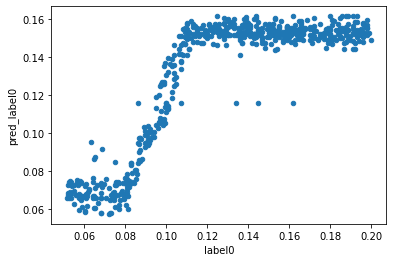

In [26]:
df_out_samples.plot(x ='label0', y='pred_label0', kind = 'scatter')
plt.show()

In [27]:
out_label.shape

(3,)

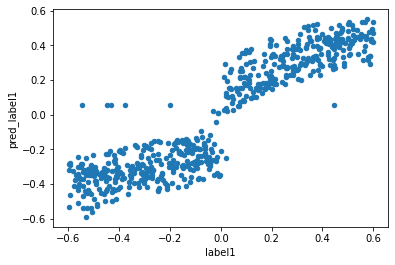

In [28]:
df_out_samples.plot(x ='label1', y='pred_label1', kind = 'scatter')
plt.show()

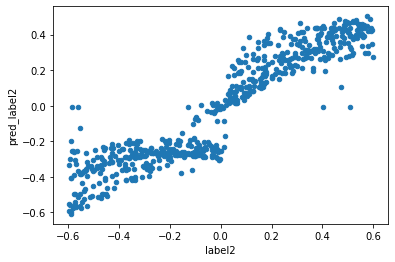

In [29]:
df_out_samples.plot(x ='label2', y='pred_label2', kind = 'scatter')
plt.show()

In [30]:
# expt_arr_n = expt_arr[np.newaxis,:,:]
# expt_arr_n.shape

In [31]:

# img = torch.from_numpy(expt_arr_n[0]).float()
# img=torch.flatten(img).to(device)

# encoder.eval().to(device)
# decoder.eval().to(device)

# with torch.no_grad():
#   decoded_img = decoder(encoder(img))

# plt.plot(decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
# plt.plot(expt_arr_n[0][0],expt_arr_n[0][1])

# model.eval().to(device)
# with torch.no_grad():
#   out_label  = model(encoder(img)).cpu().numpy()


[-5.0898714e+00 -3.1260159e+00  3.3490622e-05]


,l1,l2,l3,label0,label1,label2
0,-5.089871,-3.126016,0.000033,0.013643,-0.108729,-0.714807


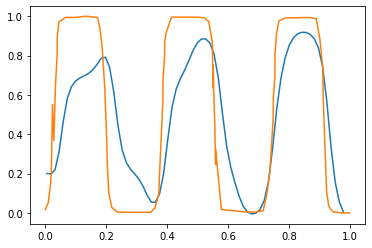

In [32]:
expt_arr_n = expt_arr[np.newaxis,:,:]
# expt_arr_n.shape

expt_labels = []

img = torch.from_numpy(expt_arr_n[0]).float()
img=torch.flatten(img).to(device)

encoder.eval().to(device)
decoder.eval().to(device)

with torch.no_grad():
  encoded_img  = encoder(img)
  expt_decoded_img = decoder(encoded_img)
  encoded_img = encoded_img.flatten().cpu().numpy()

  print(encoded_img)
  expt_label = {f"l{i+1}": enc for i, enc in enumerate(encoded_img)}

model.eval().to(device)
with torch.no_grad():
  out_label  = model(encoder(img)).cpu().numpy()

for i in range(nlabel):
    label_index = 'label'+str(i)
    expt_label[label_index] = out_label[i]

plt.plot(expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1]) 
plt.plot(expt_arr_n[0][0],expt_arr_n[0][1])

expt_labels.append(expt_label)
df_expt_labels = pd.DataFrame(expt_labels)
df_expt_labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


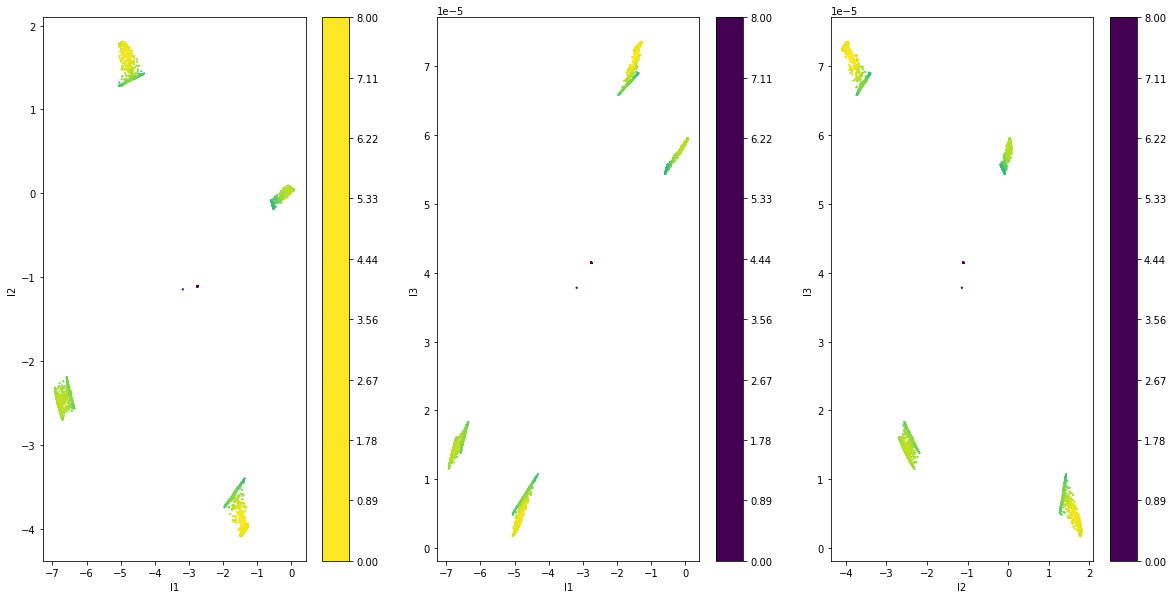

In [33]:
#Plotting the joint distributions for the latent variables for the simulated sld files
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,3,1)
x = df_encoded_samples['l1']
y = df_encoded_samples['l2']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('l1')
ax.set_ylabel('l2')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


ax = fig.add_subplot(1,3,2)
x = df_encoded_samples['l1']
y = df_encoded_samples['l3']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('l1')
ax.set_ylabel('l3')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');


ax = fig.add_subplot(1,3,3)
x = df_encoded_samples['l2']
y = df_encoded_samples['l3']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# ax.set_title('l1')
sc=ax.scatter(x, y, c=z, s=5, edgecolor='')
ax.set_xlabel('l2')
ax.set_ylabel('l3')
plt.colorbar(sc,boundaries=np.linspace(0,8,10),format='%.2f');

,l1,l2,l3,label0,label1,label2
0,-5.700000,-2.500000,-0.500000,-0.011260,-0.127449,-0.648070
1,-5.588889,-2.388889,-0.388889,-0.018803,-0.139072,-0.585419
2,-5.477778,-2.277778,-0.277778,-0.010299,-0.139509,-0.510647
3,-5.366667,-2.166667,-0.166667,-0.001795,-0.139946,-0.435875
4,-5.255556,-2.055556,-0.055556,0.007133,-0.141119,-0.357727
5,-5.144444,-1.944444,0.055556,0.018591,-0.146697,-0.259395
6,-5.033333,-1.833333,0.166667,0.031758,-0.153327,-0.143572
7,-4.922222,-1.722222,0.277778,0.045066,-0.187482,-0.088906
8,-4.811111,-1.611111,0.388889,0.042384,-0.174620,-0.083791
9,-4.700000,-1.500000,0.500000,0.039701,-0.161757,-0.078676


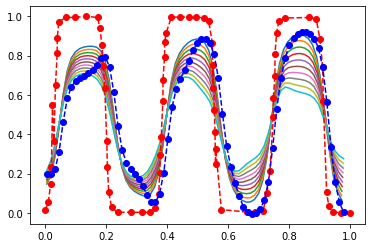

In [34]:
#Varying l1, l2 and l3 around the values above
lv1_vals = np.linspace(-5.7,-4.7,10)
lv2_vals = np.linspace(-2.5,-1.5,10)
lv3_vals = np.linspace(-.5,.5,10)
lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None], lv3_vals[:, None]), axis=-1)
lv_vals = torch.from_numpy(lv_vals).float().to(device)

#Determining the labels and the decoded images for those l1,l2,l3 above
model.eval().to(device)
with torch.no_grad():
  out_label  = model(lv_vals).cpu().numpy()
# out_label.shape

encoder.eval().to(device)
decoder.eval().to(device)

with torch.no_grad():
  decoded_img = decoder(lv_vals)

for x in range(decoded_img.shape[0]):
  plt.plot(decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[0],decoded_img[x].cpu().reshape(in_d1,in_d2).numpy()[1])
plt.plot(expt_arr_n[0][0],expt_arr_n[0][1],'ro',linestyle='dashed')
plt.plot(expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[0],expt_decoded_img.cpu().reshape(in_d1,in_d2).numpy()[1],'bo',linestyle='dashed') 

deg_model = pd.DataFrame({'l1':lv_vals.cpu().numpy()[:,0],'l2':lv_vals.cpu().numpy()[:,1],'l3':lv_vals.cpu().numpy()[:,2],
                       'label0': out_label[:,0],'label1':out_label[:,1],'label2':out_label[:,2]})
deg_model

In [35]:
# deg_model = pd.DataFrame({'l1':lv_vals.cpu().numpy()[:,0],'l2':lv_vals.cpu().numpy()[:,1],'l3':lv_vals.cpu().numpy()[:,2],
#                        'label0': out_label[:,0],'label1':out_label[:,1],'label2':out_label[:,2]})
# deg_model